# KumoRFM `rel-bench` Evaluation

This notebook provides a step-by-step guide on how to evaluate the performance of `KumoRFM` on custom tasks.
Here, we use the `rel-bench` suite as an example, but the provided guide is applicable to other datasets and tasks as well.

Let's start by installing the necessary packages:

In [ ]:
!pip install kumoai --pre --upgrade
!pip install relbench

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 283.6/283.6 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 4.9 MB/s eta 0:00:00
  Attempting uninstall: kumo-api
    Found existing installation: kumo-api 0.28.0
    Uninstalling kumo-api-0.28.0:
      Successfully uninstalled kumo-api-0.28.0
  Attempting uninstall: kumoai
    Found existing installation: kumoai 2.7.0.dev202508031832
    Uninstalling kumoai-2.7.0.dev202508031832:
      Successfully uninstalled kumoai-2.7.0.dev202508031832


In [ ]:
from kumoai.experimental import rfm

Ensure that we are authorized:

In [ ]:
import os

if not os.environ.get("KUMO_API_KEY"):
    rfm.authenticate()

In [ ]:
rfm.init()

INFO:kumoai:Successfully initialized the Kumo SDK against deployment https://kumorfm.ai/api, with log level INFO.


Next, we write a simple function that helps us to convert any `rel-bench` dataset into a graph applicable for downstream use in `KumoRFM`:

In [ ]:
from relbench.datasets import get_dataset

def get_relbench_graph(name: str) -> rfm.LocalGraph:
    # A helper function to create a `rfm.LocalGraph` from a `rel-bench` dataset:
    db = get_dataset(name, download=True).get_db(upto_test_timestamp=False)
    df_dict = {name: table.df for name, table in db.table_dict.items()}
    graph = rfm.LocalGraph.from_data(df_dict, infer_metadata=False)

    for table_name, table in db.table_dict.items():  # Set graph metadata:
        graph[table_name].primary_key = table.pkey_col
        graph[table_name].time_column = table.time_col
        for fkey, dst_table in table.fkey_col_to_pkey_table.items():
            graph.link(table_name, fkey, dst_table)
    return graph

For this example, we make use of the `rel-f1` dataset:

In [ ]:
graph = get_relbench_graph('rel-f1')

We can easily ensure that everything is set up correctly:

In [ ]:
graph.print_metadata()
graph.print_links()

### 🗂️ Graph Metadata

name,primary_key,time_column
qualifying,qualifyId,date
results,resultId,date
races,raceId,date
constructors,constructorId,-
constructor_results,constructorResultsId,date
drivers,driverId,-
constructor_standings,constructorStandingsId,date
standings,driverStandingsId,date
circuits,circuitId,-


### 🕸️ Graph Links (FK ↔️ PK)

- `races.circuitId` ↔️ `circuits.circuitId`
- `constructor_results.constructorId` ↔️ `constructors.constructorId`
- `constructor_standings.constructorId` ↔️ `constructors.constructorId`
- `qualifying.constructorId` ↔️ `constructors.constructorId`
- `results.constructorId` ↔️ `constructors.constructorId`
- `qualifying.driverId` ↔️ `drivers.driverId`
- `results.driverId` ↔️ `drivers.driverId`
- `standings.driverId` ↔️ `drivers.driverId`
- `constructor_results.raceId` ↔️ `races.raceId`
- `constructor_standings.raceId` ↔️ `races.raceId`
- `qualifying.raceId` ↔️ `races.raceId`
- `results.raceId` ↔️ `races.raceId`
- `standings.raceId` ↔️ `races.raceId`

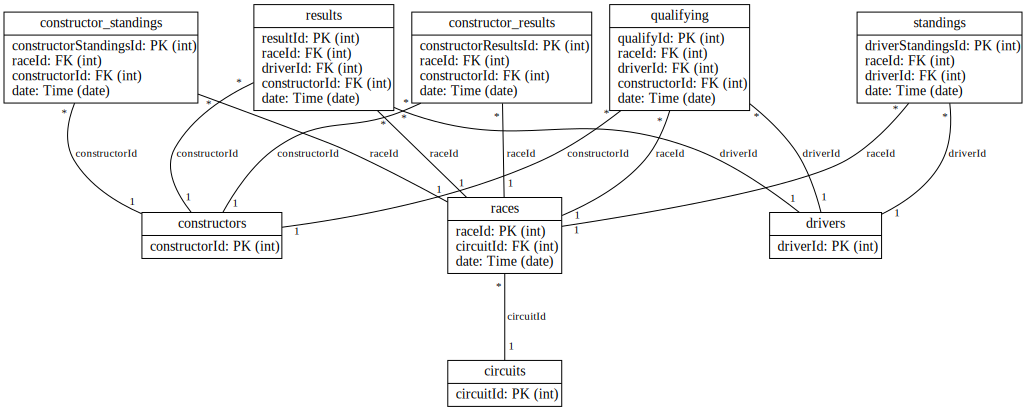

In [ ]:
graph.visualize(show_columns=False);

There exists **two ways** on how to evaluate `KumoRFM` on custom datasets and tasks:

1. We inject training labels and test entities via a **custom context table**. This bypasses the predictive query language and can be set up for any task.
1. We replicate the `rel-bench` setup via the **predictive query language**.

In what follows, we show how to set things up for both cases:

## Custom Context Table

The idea is simple: We attach a context table to the graph which contains the training and test entities, their timestamps, and training labels. For the test entities, we **keep their labels blank** and ask `KumoRFM` to infer them.
With this scheme, we can support any classification or regressions task by interpreting them as **missing value imputation**.

For `rel-bench`, we can do this by concatenating the task-specific training tables across the different splits, but ensure that we mask out all final test labels to prevent leakage.

Let's look at an example for the `user-ignore` task on the `rel-event` dataset:

In [ ]:
import pandas as pd
from relbench.tasks import get_task

task = get_task('rel-f1', 'driver-top3', download=True)

In [ ]:
# Concatenate training labels into a single `pd.DataFrame`:
context_dfs = []
for split in ['test', 'val', 'train']:
    df = task.get_table(split, mask_input_cols=False).df
    df = df.drop(columns='index', errors='ignore')
    df[task.target_col] = df[task.target_col].astype('Int64')
    if split == 'test':
        df[task.target_col] = None  # Do not leak test labels.
    context_dfs.append(df)
context_df = pd.concat(context_dfs, axis=0, ignore_index=True).reset_index()

# Assign this `pd.DataFrame` to a table in the graph:
context_table = rfm.LocalTable(
    context_df,
    name='context',
    primary_key='index',
    time_column=task.time_col,
)
graph.add_table(context_table)
graph.link(context_table.name, task.entity_col, task.entity_table)

context_table.print_metadata()

/tmp/ipython-input-2406769957.py:10: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  context_df = pd.concat(context_dfs, axis=0, ignore_index=True).reset_index()


### 🏷️ Metadata of Table `context` (2,667 rows)

name,dtype,stype,is_primary_key,is_time_column
index,int,ID,True,False
date,date,timestamp,False,True
driverId,int,ID,False,False
qualifying,int,categorical,False,False


In the above snippet, note that we add a **primary key** `index` to the context table - a unique identifier to be able to reference any row within that table.
This is needed to be able to later predict for individual rows within that table.

We are now ready to evaluate `KumoRFM` on the `driver-top3` task:

In [ ]:
model = rfm.KumoRFM(graph)

Output()

Our predictive query now simply performs missing value imputation for the target column in the context table. In order to cast this into a binary classification problem, we explicitely add a condition to the target clause (*i.e.* `target_col = 1`):

In [ ]:
query = (f"PREDICT context.{task.target_col} = 1 "
         f"FOR context.index IN ({{indices}})")

We are now ready to iterate over all test entities (with a batch size up to `1000`) and obtain their predictions. In order to speed things up, we only run over a subset of test entities (defined by `max_test_steps`):

In [ ]:
import tqdm
import numpy as np

batch_size = 1000
max_test_steps = 20

ys_pred = []
test_df = task.get_table('test', mask_input_cols=False).df
steps = list(range(0, len(test_df), batch_size))[:max_test_steps]
for i, step in enumerate(tqdm.tqdm(steps)):
    indices = range(step, min(step + batch_size, len(test_df)))
    _query = query.format(indices=', '.join(str(i) for i in indices))
    df = model.predict(
        _query,
        run_mode='best',  # Trades runtime in favor of better model performance.
        anchor_time='entity',  # Use context table time as anchor time.
        num_neighbors=[8, 8, 8],  # Need to increase by 1.
        verbose=i == 0,  # Prevent excessive logging.
    )
    ys_pred.append(df['True_PROB'].to_numpy())

y_pred = np.concatenate(ys_pred)

  0%|          | 0/1 [00:00<?, ?it/s]

Output()

100%|██████████| 1/1 [00:02<00:00,  2.00s/it]


There exists a few things to look out for in the code snippet above:

* `KumoRFM.predict(...)` supports different **`run_mode`** configurations (`"fast"`, `"normal"`, `"best"`), which determine the context size, neighbor sampling parameters, and model configurations. By default, this is set to `"fast"`. Here, we are interested in the best possible performance.
* The **`anchor_time`** supports two options: **(1)** a `pd.Timestamp(...)` that denotes the absolute time for when we are making a prediction; **(2)** the string `"entity"`, which tells `KumoRFM` to use the timestamp of the context table row as its individual anchor timestamp. In this case, we use `anchor_time="entity"` since this is needed to mimic the original `rel-bench` setup.
* The **`num_neighbors`** argument defines the depth of subgraphs and how many neighbors to sample in each hop. If unspecified, we are sampling at most two hops (which is sufficient in most cases). Since in our case we added an additional context table to the graph, we need one hop more to recover the original 2-hop sampling approach (since we first need to go from `context` to `drivers`). As such, we increase the number of hops to 3 (`len(num_neighbors) == 3`). It is important to point out that tuning the number of neighbors can be beneficial to reach maximum performance. In some cases, reducing number of neighbors avoids oversmoothing, in other cases increasing number of neighbors enables us to look at a larger historical window. In this case, we find it sufficient to sample 8 neighbors in each hop.
* The **`verbose`** option ensures that we do not log within intermediate steps.

Finally, we can compute metrics based on the given ground-truth information from the `rel-bench` test set:

In [ ]:
from sklearn.metrics import roc_auc_score

y_test = test_df[task.target_col].to_numpy().astype(int)[:len(y_pred)]
print(f'AUROC: {roc_auc_score(y_test, y_pred):.4f}')

AUROC: 0.9064


This setup lets us benchmark any `rel-bench` task without further modifications required. If you run this set up on other tasks, results should (mostly) look as follows:

| Dataset | Task | #Neighbors | AUROC |
| - | - | - | - |
| `rel-f1` | `driver-top3` | 8 | 90.64 |
| `rel-f1` | `driver-dnf` | 16 | 81.98 |
| `rel-hm` | `user-churn` | 64 | 68.82 |
| `rel-avito` | `user-clicks` | 128 | 63.81 |
| `rel-avito` | `user-visits` | 128 | 63.81 |
| `rel-event` | `user-repeat` | 64 | 76.87 |
| `rel-event` | `user-ignore` | 16 | 85.52 |
| `rel-stack` | `user-engagement` | 8 | 86.8 |
| `rel-stack` | `user-badge` | 8 | 84.09 |
| `rel-trial` | `study-outcome` | 64 | 71.54 |
| **Average** | | | **77.39** |

## Predictive Query Language

Besides the context table approach, the real beauty of `KumoRFM` comes into play once we define a task via our expressive **Predictive Query Language (PQL)**.

For example, the `driver-top3` query on the `rel-f1` dataset denotes whether a driver will qualify in the top-3 for a race within the next 30 days. In PQL, we can write this as:

In [ ]:
query = ("PREDICT MIN(qualifying.position, 0, 30, days)<=3 "
         "FOR drivers.driverId IN ({indices})")

Other tasks on other datasets can be easily written via PQL as well. For example, the `user-churn` task on `rel-hm` is defined as

In [ ]:
("PREDICT COUNT(transactions.*, 0, 7, days)=0 "
 "FOR customer.customer_id IN ({indices}) "
 "WHERE COUNT(transactions.*, -7, 0, days)>0");

which defines churn for an active customer (at least one transaction in the last week) as having no transaction in the next week.

Whenever defining a task via PQL, it is important to ensure that the task is correctly formulated (especially around entity filters). For this, `KumoRFM` allows us to inspect and debug generated label information for a specific `anchor_time` via the `KumoRFM.get_train_table(...)` helper function:

In [ ]:
# Remove context table - we no longer need it:
del graph['context']

# Ensure that target column has correct semantic type:
graph['qualifying']['position'].stype = 'numerical'

model = rfm.KumoRFM(graph)

Output()

In [ ]:
train_table = model.get_train_table(
    query.format(indices='0, 1'),  # Dummy values.
    size=100,
    anchor_time=pd.Timestamp('2013-03-16'),
)
display(train_table)

,ENTITY,ANCHOR_TIMESTAMP,TARGET
0,822,2013-03-16,False
1,812,2013-03-16,False
2,7,2013-03-16,True
3,2,2013-03-16,False
4,0,2013-03-16,True
5,12,2013-03-16,True
6,814,2013-03-16,False
7,817,2013-03-16,False
8,3,2013-03-16,True
9,153,2013-03-16,False


Let's make sure that these labels align with the labels in the `rel-bench` training table:

In [ ]:
test_df = task.get_table('test', mask_input_cols=False).df

train_table['TARGET'] = train_table['TARGET'].astype(int)  # Align dtypes.
train_table = train_table.rename(columns={  # Align column names:
    'ENTITY': task.entity_col,
    'ANCHOR_TIMESTAMP': task.time_col,
    'TARGET': task.target_col,
})
assert train_table.isin(test_df.to_dict(orient='list')).all(axis=None)

Once we confirmed that everything behaves correctly, we are ready to query.
Since `rel-bench` datasets may contain multiple anchor timestamps, we first group entities by their anchor timestamp, and then split entities within the same anchor timestamp into chunks of size `batch_size`. This ensures that for a single `model.predict(...)` call, we use the same anchor time in order to be able to share the context among all entities to predict for:


In [ ]:
batch_size = 1000
max_test_steps = 20

nested_test_df = test_df.groupby(task.time_col)[[
    task.entity_col,
    task.target_col,
]].agg(list)
display(nested_test_df)

test_indices = []
for anchor_time, row in nested_test_df.iterrows():
    for step in range(0, len(row[task.entity_col]), batch_size):
        test_indices.append((
            anchor_time,
            row[task.entity_col][step:step + batch_size],
            row[task.target_col][step:step + batch_size],
        ))

# Limit the number of test steps:
test_indices = test_indices[:max_test_steps]

,driverId,qualifying
date,,
2010-03-02,"[0, 16, 15, 9, 17, 154, 14, 808, 811, 2, 29, 6...","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ..."
2010-04-01,"[808, 811, 2, 29, 0, 16, 15, 9, 17, 14, 154, 4...","[0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2010-05-01,"[810, 36, 12, 152, 807, 809, 3, 4, 23, 21, 66,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, ..."
2010-05-31,"[152, 809, 807, 3, 36, 810, 12, 23, 4, 21, 8, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ..."
2010-06-30,"[12, 810, 36, 807, 3, 152, 809, 23, 4, 21, 8, ...","[1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ..."
2010-07-30,"[36, 810, 12, 809, 152, 807, 3, 23, 4, 21, 66,...","[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, ..."
2010-08-29,"[1, 21, 66, 19, 8, 809, 807, 3, 152, 810, 12, ...","[0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, ..."
2010-09-28,"[23, 4, 810, 12, 152, 809, 3, 807, 66, 19, 8, ...","[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, ..."
2010-10-28,"[17, 9, 14, 154, 31, 15, 0, 16, 29, 2, 808, 1,...","[0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, ..."


Afterwards, we can predict on each batch of entities (up to `1000`) that share the same anchor timestamp. This time, we pass an absolute `anchor_time` to each `model.predict(...)` call (which corresponds to the timestamp of the test set for the entities we are making a prediction for):

In [ ]:
import tqdm
import numpy as np

ys_test = []
ys_pred = []
for i, (anchor_time, indices, y_test) in enumerate(tqdm.tqdm(test_indices)):
    _query = query.format(indices=', '.join(str(i) for i in indices))
    df = model.predict(
        _query,
        run_mode='best',
        anchor_time=anchor_time,
        max_pq_iterations=200,  # Ensure enough context labels are found.
        verbose=i == 0,  # Prevent excessive logging.
    )
    ys_pred.append(df['True_PROB'].to_numpy())
    ys_test.append(np.array(y_test))

y_pred = np.concatenate(ys_pred)
y_test = np.concatenate(ys_test)

  0%|          | 0/20 [00:00<?, ?it/s]

Output()

100%|██████████| 20/20 [01:27<00:00,  4.38s/it]


One thing to point out here is that we utilize **`max_pq_iterations`** and increase its initial value from `20` to `200`. We do this in order to find sufficient context labels in the data. Often times, no adjustments are needed to the default setting, but if your predictive query comes with restrictive entity filters (*e.g.*, in our case we are only operating on active drivers defined via the `MIN` clause), it might be beneficial to increase this value in order to ensure that sufficient valid entity/timestamp pairs are found to form context.

Finally, we are ready to compute metrics on top:

In [ ]:
from sklearn.metrics import roc_auc_score

print(f'AUROC: {roc_auc_score(y_test, y_pred):.4f}')

AUROC: 0.9346


Note that the AUROC reported here is a bit better than what we previously reported. This is due to the fact that the `driver-top3` comes with multiple test timestamps. In the predictive query setup, all information before the current `anchor_time` will be used to generate context (*i.e.* previous test timestamps can be used as part of the context), while in the context table approach, context of other test timestamps is explicitly prohibited.